In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import tqdm
from torch.optim import Adam
import matplotlib.pyplot as plt

from lib.model import FNO1d
from lib.dataset import PDEDatasetAll2All
from lib.utils import relative_l2_error

In [20]:
torch.manual_seed(0)
np.random.seed(0)

In [21]:
BATCH_SIZE = 1024
DEVICE = "cuda"

In [22]:
dataset_train = (
    PDEDatasetAll2All("data/train_allen_cahn_fourier.npy", device=DEVICE)
    + PDEDatasetAll2All("data/train_allen_cahn_gmm.npy", device=DEVICE)
    + PDEDatasetAll2All("data/train_allen_cahn_piecewise.npy", device=DEVICE)
)

print("Train dataset size:", len(dataset_train))

Train dataset size: 22500


In [23]:
training_data, validation_data = torch.utils.data.random_split(
    dataset_train, [int(0.8 * len(dataset_train)), int(0.2 * len(dataset_train))]
)

In [24]:
train_data_loader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
val_data_loader = DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle=True)

In [25]:
learning_rate = 0.001
epochs = 100
step_size = 20
gamma = 0.5

In [26]:
modes = 16
width = 64
fno = FNO1d(modes, width).to(DEVICE)  # model

In [27]:
optimizer = Adam(fno.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0 = step_size, eta_min=1e-6)

In [28]:
def loss_f(output: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    return relative_l2_error(output, target)

In [29]:
metrics = {
    "training_loss": [],
    "validation_loss": [],
    "lr": [],
}

In [30]:
progress_bar = tqdm.tqdm(range(epochs))
for epoch in progress_bar:
    fno.train()
    train_loss = 0.0
    for i, (dt, eps, input, target) in enumerate(train_data_loader):
        optimizer.zero_grad()
        prediction = fno(input, dt, eps).squeeze(-1)

        loss = loss_f(prediction, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_data_loader)

    metrics["training_loss"].append(train_loss)
    metrics["lr"].append(scheduler.get_last_lr())

    # Compute validation loss
    fno.eval()
    validation_relative_l2 = 0.0
    for i, (dt, eps, input, target) in enumerate(val_data_loader):
        with torch.no_grad():
            prediction = fno(input, dt, eps).squeeze(-1)

        loss = relative_l2_error(prediction, target)
        validation_relative_l2 += loss.item()

    validation_relative_l2 /= len(val_data_loader)
    metrics["validation_loss"].append(validation_relative_l2)

    scheduler.step(validation_relative_l2)
    # Update progress bar
    progress_bar.set_postfix(
        {"train_loss": train_loss, "val_loss": validation_relative_l2},
    )

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [06:02<00:00,  3.62s/it, train_loss=0.0752, val_loss=0.105]


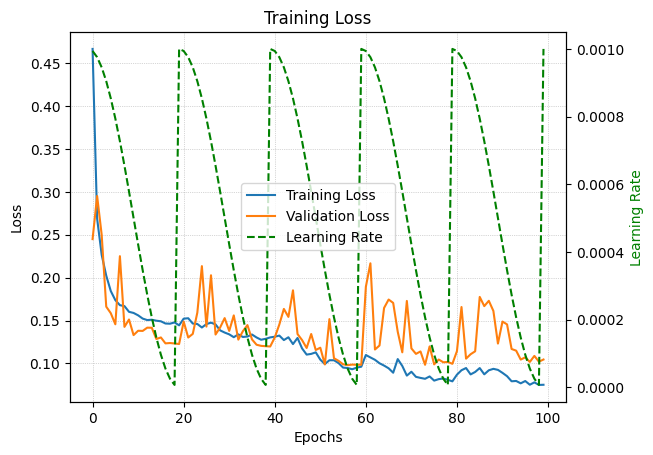

In [31]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

l1 = ax1.plot(metrics["training_loss"], label="Training Loss")
l2 = ax1.plot(metrics["validation_loss"], label="Validation Loss")
l3 = ax2.plot(metrics["lr"], label="Learning Rate", color="green", linestyle="--")

ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax2.set_ylabel("Learning Rate", color="green")
plt.title("Training Loss")

plt.legend(l1 + l2 + l3, [line.get_label() for line in l1 + l2 + l3])
ax1.grid(True, which="both", ls=":", linewidth=0.5)
plt.show()

In [32]:
time_pairs = [(0, 1), (0, 2), (0, 3), (0, 4)]
dataset_test = (
    PDEDatasetAll2All(
        "data/test_allen_cahn_fourier.npy", device=DEVICE, time_pairs=time_pairs
    )
    + PDEDatasetAll2All(
        "data/test_allen_cahn_gmm.npy", device=DEVICE, time_pairs=time_pairs
    )
    + PDEDatasetAll2All(
        "data/test_allen_cahn_piecewise.npy", device=DEVICE, time_pairs=time_pairs
    )
)
test_data_loader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)

In [33]:
fno.eval()
progress_bar = tqdm.tqdm(test_data_loader)

with torch.no_grad():
    test_relative_l2 = 0.0
    for i, (dt, eps, input, target) in enumerate(progress_bar):
        prediction = fno(input, dt, eps).squeeze(-1)

        loss = relative_l2_error(prediction, target)
        test_relative_l2 += loss.item()
    test_relative_l2 /= len(test_data_loader)

print(rf"Test relative L2 error: {test_relative_l2}")

100%|██████████| 4/4 [00:00<00:00, 13.75it/s]

Test relative L2 error: 0.10977612808346748


In [34]:
# save model to disk
torch.save(fno.state_dict(), "models/tfno_model.pth")